## Tensorflow based Pos reconstruction in XENON1T

  * Yuehuan and Fei

In [17]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [2]:
### Loading FAX simulated data frames
import pickle
df_1 = pickle.load(open('pos_df_2e5_training.pkl','rb'))
df_2 = pickle.load(open('pos_df_7e5_training.pkl','rb'))
df = pd.concat([df_1,df_2])

In [29]:
pmthits = df.loc[:,[c for c in df.columns if 'PMT' in c]].values
pmthits[np.isnan(pmthits)] = 0

list_bad_pmts = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 130, 134, 135, 139, 148, 150, 152, 162, 178, 183, 190, 198, 206, 213, 214, 234, 239, 244]
pmthits_clean = df.loc[:,[c for i, c in enumerate(df.columns) if 'PMT' in c and i not in list_bad_pmts]].values
pmthits_clean[np.isnan(pmthits_clean)] = 0

s2top = df['s2top'].values
target = df[['xp','yp']].values

In [30]:
offset = 1e-5
for i in range(len(pmthits)):
    pmthits[i] /= s2top[i] 
    pmthits_clean[i] /= s2top[i]

pmthits[np.isnan(pmthits)] = 0
pmthits_clean[np.isnan(pmthits_clean)] = 0
pmthits += offset
pmthits_clean += offset

In [31]:
pmthits[0].sum()

1.0012700149679419

In [32]:
## Training samples without removing not working PMTs
test_size = 800000
remaining_size = len(pmthits_clean) - test_size
batch_size = 1000
epochs = 20
x_train = pmthits_clean[:test_size]
y_train = target[:test_size]
x_test = pmthits_clean[:-test_size]
y_test = target[:-test_size]

## Using Keras API

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy
from keras import regularizers

In [34]:
# define the model
def MLP(activation='elu', reg_scale=0.01, keep_rate=0.2):
    # create model
    model = Sequential()
    model.add(Dense(len(x_train[0]), input_dim=len(x_train[0])))
    model.add(Dense(100, kernel_initializer='normal', activation=activation, bias_initializer='zeros', use_bias=True, kernel_regularizer = regularizers.l2(reg_scale)))
    model.add(Dropout(keep_rate))
    model.add(Dense(80, kernel_initializer='normal', activation=activation, bias_initializer='zeros', use_bias=True, kernel_regularizer = regularizers.l2(reg_scale)))
    model.add(Dropout(keep_rate))
    model.add(Dense(40, kernel_initializer='normal', activation=activation, bias_initializer='zeros', use_bias=True, kernel_regularizer = regularizers.l2(reg_scale)))
    model.add(Dropout(keep_rate))    
    model.add(Dense(2))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [35]:
test_model = MLP() #KerasRegressor(build_fn=MLP, epochs=10, batch_size=50, verbose=1)
test_model.fit(x_train, y_train, batch_size=batch_size, validation_split=0.1, epochs=epochs, verbose=2)

Train on 720000 samples, validate on 80000 samples
Epoch 1/20
 - 8s - loss: 61.0450 - val_loss: 3.0560
Epoch 2/20
 - 8s - loss: 22.4727 - val_loss: 2.6928
Epoch 3/20
 - 8s - loss: 21.1910 - val_loss: 2.3087
Epoch 4/20
 - 8s - loss: 20.2666 - val_loss: 2.0105
Epoch 5/20
 - 8s - loss: 19.4935 - val_loss: 2.0125
Epoch 6/20
 - 8s - loss: 18.9574 - val_loss: 1.9949
Epoch 7/20
 - 9s - loss: 18.5521 - val_loss: 1.9244
Epoch 8/20
 - 9s - loss: 18.2039 - val_loss: 2.0688
Epoch 9/20
 - 9s - loss: 17.9611 - val_loss: 1.8609
Epoch 10/20
 - 9s - loss: 17.7751 - val_loss: 2.1003
Epoch 11/20
 - 9s - loss: 17.5855 - val_loss: 2.0290
Epoch 12/20
 - 8s - loss: 17.3142 - val_loss: 1.8723
Epoch 13/20
 - 8s - loss: 17.1634 - val_loss: 1.9354
Epoch 14/20
 - 9s - loss: 17.0629 - val_loss: 2.0423
Epoch 15/20
 - 9s - loss: 17.0177 - val_loss: 1.8694
Epoch 16/20
 - 9s - loss: 16.8874 - val_loss: 1.7844
Epoch 17/20
 - 12s - loss: 16.8681 - val_loss: 1.7119
Epoch 18/20
 - 12s - loss: 16.7831 - val_loss: 1.8771
Ep

In [36]:
y_pred_te = test_model.predict(x_test)

In [37]:
x_test.shape

(100000, 115)

In [38]:
y_pred_tr = test_model.predict(x_train)

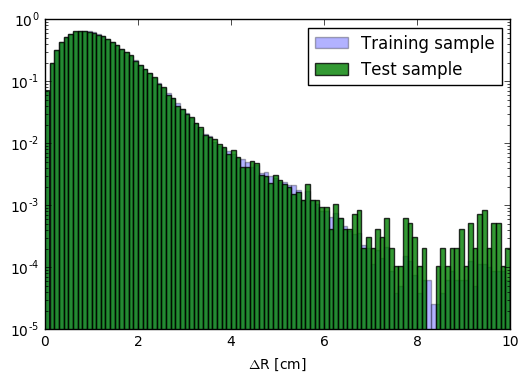

In [39]:
plt.hist(np.sqrt((y_pred_tr[:,0]-y_train[:,0])**2+(y_pred_tr[:,1]-y_train[:,1])**2),bins=200,normed=True, range=(0,20), alpha=0.3, label='Training sample')
plt.hist(np.sqrt((y_pred_te[:,0]-y_test[:,0])**2+(y_pred_te[:,1]-y_test[:,1])**2),bins=200,normed=True, range=(0,20), alpha=0.8, label='Test sample')

plt.legend()
plt.yscale('log')
plt.xlabel('${\Delta}$R [cm]')
plt.xlim(0,10)
plt.show()

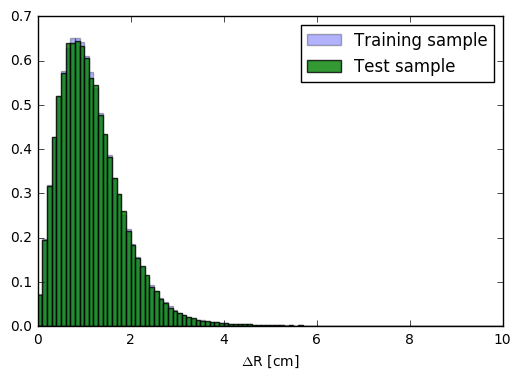

In [40]:
plt.hist(np.sqrt((y_pred_tr[:,0]-y_train[:,0])**2+(y_pred_tr[:,1]-y_train[:,1])**2),bins=200,normed=True, range=(0,20), alpha=0.3, label='Training sample')
plt.hist(np.sqrt((y_pred_te[:,0]-y_test[:,0])**2+(y_pred_te[:,1]-y_test[:,1])**2),bins=200,normed=True, range=(0,20), alpha=0.8, label='Test sample')

plt.legend()
#plt.yscale('log')
plt.xlabel('${\Delta}$R [cm]')
plt.xlim(0,10)
plt.show()

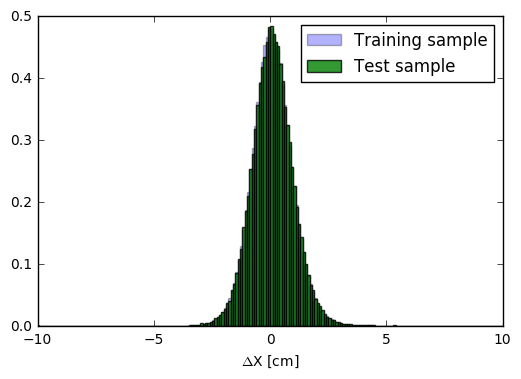

In [41]:
plt.hist(y_pred_tr[:,0]-y_train[:,0],bins=200,normed=True, range=(-10,10), alpha=0.3, label='Training sample')
plt.hist(y_pred_te[:,0]-y_test[:,0],bins=200,normed=True, range=(-10,10), alpha=0.8, label='Test sample')

plt.legend()
#plt.yscale('log')
plt.xlabel('${\Delta}$X [cm]')
plt.xlim(-10,10)
plt.show()

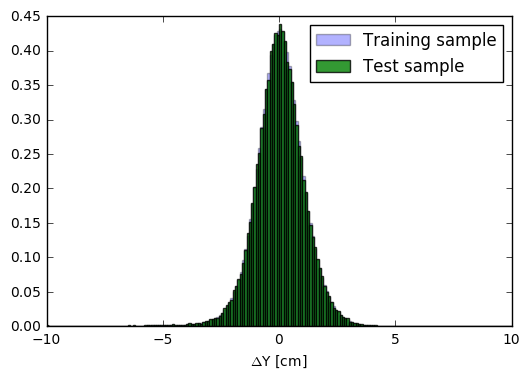

In [42]:
test = plt.hist(y_pred_tr[:,1]-y_train[:,1],bins=200,normed=True, range=(-10,10), alpha=0.3, label='Training sample')
plt.hist(y_pred_te[:,1]-y_test[:,1],bins=200,normed=True, range=(-10,10), alpha=0.8, label='Test sample')

plt.legend()
#plt.yscale('log')
plt.xlabel('${\Delta}$Y [cm]')
plt.xlim(-10,10)
plt.show()

In [28]:
np.mean(y_test[:,1]-y_test[:,0])

0.077650608522821768

## Using plain Tensorflow, does not converge yet, don't try

In [ ]:
import tensorflow as tf
tf.reset_default_graph()

n_inputs = len(x_train[0])
n_hidden1 = 100
n_hidden2 = 80
n_outputs = 1
learning_rate = 0.01

tf_x = tf.placeholder(tf.float32, shape=(None, n_inputs), name="tf_x")
tf_y = tf.placeholder(tf.float32, shape=(None), name="tf_y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(tf_x, n_hidden1, activation=tf.nn.elu, name="hidden1")
#    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu, name="hidden2")
    output = tf.layers.dense(hidden1, n_outputs,activation=tf.nn.elu,name="outputs")

with tf.name_scope("loss"):
    loss = tf.losses.mean_squared_error(tf_y, output)  # compute cost

with tf.name_scope("train"):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    evaluation = tf.losses.mean_squared_error(tf_y, output)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(epochs):
        #sess.run([train_op, loss, output], {X: x_train, y: y_train})
        sess.run(training_op, {tf_x: x_train, tf_y: y_train})
        losst = evaluation.eval(feed_dict={tf_x: x_train, tf_y: y_train})
        if epoch % 5 ==0:
            print(losst)

## Using Convolutional NN, don't try yet

In [ ]:
'''This example demonstrates the use of Convolution1D for text classification.
Gets to 0.89 test accuracy after 2 epochs.
90s/epoch on Intel i5 2.4Ghz CPU.
10s/epoch on Tesla K40 GPU.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras import regularizers

# set parameters:
max_features = 5000
maxlen = 400
batch_size = 100
embedding_dims = 50
filters = 50
kernel_size = 3
hidden_dims = 50
epochs = 5
test_size = 500
print('Loading data...')
#(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(pmthits), 'train sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(pmthits[:test_size], maxlen=maxlen)
y_train = target[:test_size]
print('x_train shape:', x_train.shape)
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='elu',
                 #kernel_regularizer = regularizers.l2(0.001),
                 # bias_regularizer=regularizers.l1(0.0001),
                 #activity_regularizer=regularizers.l1(0.01),
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims,
                #kernel_regularizer = regularizers.l2(0.0001),
                # bias_regularizer=regularizers.l1(0.0001),
                #activity_regularizer=regularizers.l1(0.01)
               ))
model.add(Dropout(0.5))
#model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
#model.add(Activation('sigmoid'))
model.add(Activation('relu'))

model.compile(loss='mean_squared_error',
              optimizer='adam')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs)

In [ ]:
result = model.predict(x_train)

#((result - y_train)**2).sum()

In [ ]:
y_train